# Libraries

In [1]:
%pip install torchsummary
%pip install gdown

Note: you may need to restart the kernel to use updated packages.



In [2]:
import os
import shutil
import json
import matplotlib.pyplot as plt
import random
import PIL.Image as Image
import numpy as np
import pandas as pd
import time
import shutil
import math
import pathlib
import sys


from mpl_toolkits.axes_grid1 import ImageGrid

from skimage.restoration import denoise_tv_chambolle
import cv2
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import torchsummary as summary

import tensorflow as tf
import keras

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.preprocessing.image import Iterator
from keras.utils.np_utils import to_categorical
import keras.backend as K

plt.ion()
from IPython.display import clear_output

## Download Dataset

In [3]:
# # dataset link: https://www.kaggle.com/sthabile/noisy-and-rotated-scanned-documents
# !gdown --id 1JitIKYYGZA69IYOuAf2E_GGH6oj5wNm8

# try:
#     os.mkdir('dataset')
# except:
#     pass
# !unzip -qq /content/archive.zip -d dataset

## Preparing Paths of Dataset

In [4]:
try:
    os.mkdir('dataset')
except:
    pass
#!cp ../input/noisy-and-rotated-scanned-documents/scan_doc_rotation -r ./dataset

root = './dataset'         
image_paths = os.path.join(root, 'images')
label_paths = os.path.join(root, 'labels')

### test list

In [5]:
test_list_path = os.path.join(root, 'test_list.json')   

with open(test_list_path) as f:
    test_list = json.load(f)

### train list

In [6]:
train_list_path = os.path.join(root, 'train_list.json')

with open(train_list_path) as f:
    train_list = json.load(f)

label_list = [x.split('.')[0] + '.txt' for x in train_list]

## Sample

### Single Image

In [7]:
def get_random_img(r=[0, 499]):
    id = random.randint(r[0], r[1])
    sample_image_path = os.path.join(image_paths, train_list[id])
    sample_label_path = os.path.join(label_paths, label_list[id])
    return id, sample_image_path, sample_label_path

In [8]:
def display_image(path=None, img=None):
    if path is not None:
        img = Image.open(path)

    plt.figure(figsize=(8, 8))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray');

ID of document is : 298
Rotation angle is : -0.1892014472351793


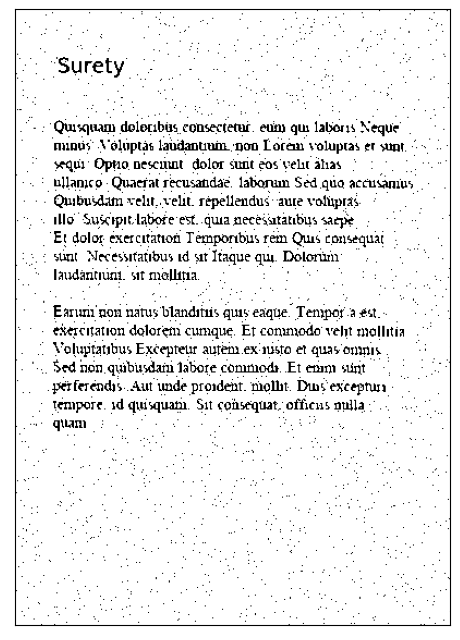

In [9]:

id, sample_image_path, sample_label_path = get_random_img()

display_image(path=sample_image_path)

with open(sample_label_path) as f:
    angle = f.read()
print('ID of document is :', id)
print('Rotation angle is :', angle)

### ImageGrid

In [10]:
def display_image_grid(images, n=10, angles=None):
    fig = plt.figure(figsize=(20, 20))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(n, n),  
                     axes_pad=0.25, 
                     )

    i = 0
    for ax, im in zip(grid, images):
        ax.imshow(im, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        if angles is not None:
            angle = angles[i] - 5
            ax.set_title(label=str(angle))
        i += 1

    plt.show()

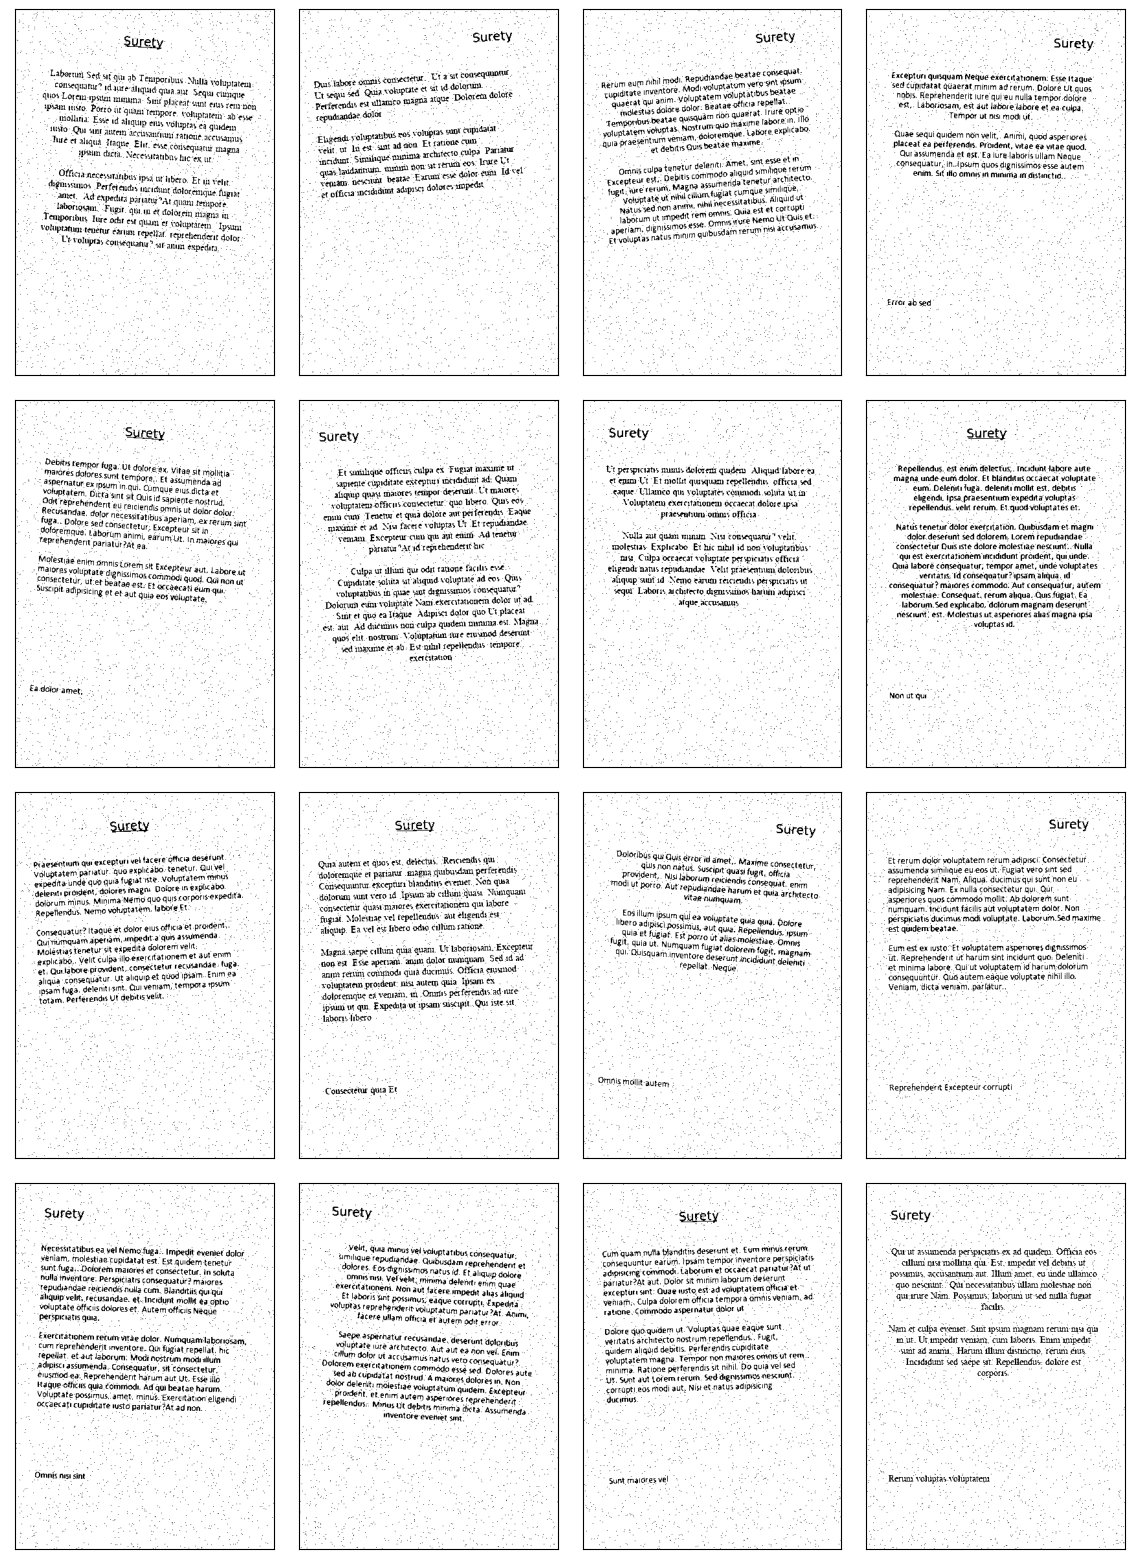

In [11]:
sampled_images = []
sampled_ids = []

for i in range(16):
    id, sample_image_path, sample_label_path = get_random_img()
    if id not in sampled_ids:
        img = Image.open(sample_image_path)
        sampled_ids.append(id)
        sampled_images.append(img)

display_image_grid(sampled_images, 4)

<a href='https://github.com/d4nst/RotNet'>RotNet</a> repo

In [12]:
!git clone https://github.com/d4nst/RotNet.git

fatal: destination path 'RotNet' already exists and is not an empty directory.


## Import Functions

In [13]:
from shutil import copyfile

copyfile(src = "./RotNet/utils.py", dst = "my_functions.py")

from my_functions import *

## Building Better Dataset 

We deskew(correct rotation) images of the dataset and rotate them between (-45, 45) degrees, since the images are homogeneous in-terms of rotation, due to the rotation range of [-5, 5] degress. In other words, We are doing data augmentation by rotating images.

In [14]:
labels = {}
for textfile in label_list:
    path = os.path.join(label_paths, textfile)
    with open(path) as f:
        label = float(f.read())
    file_name = textfile.split('.')[0]
    labels[file_name] = label

In [15]:
new_images = []
new_labels = []
for image_id, angle in labels.items():
    image_path = os.path.join(image_paths, image_id+'.png')
    img = Image.open(image_path)                                
    img = np.array(img)                                         
    corrected_img = rotate(img, -angle)                         
    
    sample_angles = random.sample(range(-45, 45), 50)           
    for sample_angle in sample_angles:
        new_img = generate_rotated_image(corrected_img,         
                                         sample_angle,          
                                         size=(128, 128),
                                         crop_center=True,
                                         crop_largest_rect=True)
        new_images.append(new_img)
        new_labels.append(sample_angle)

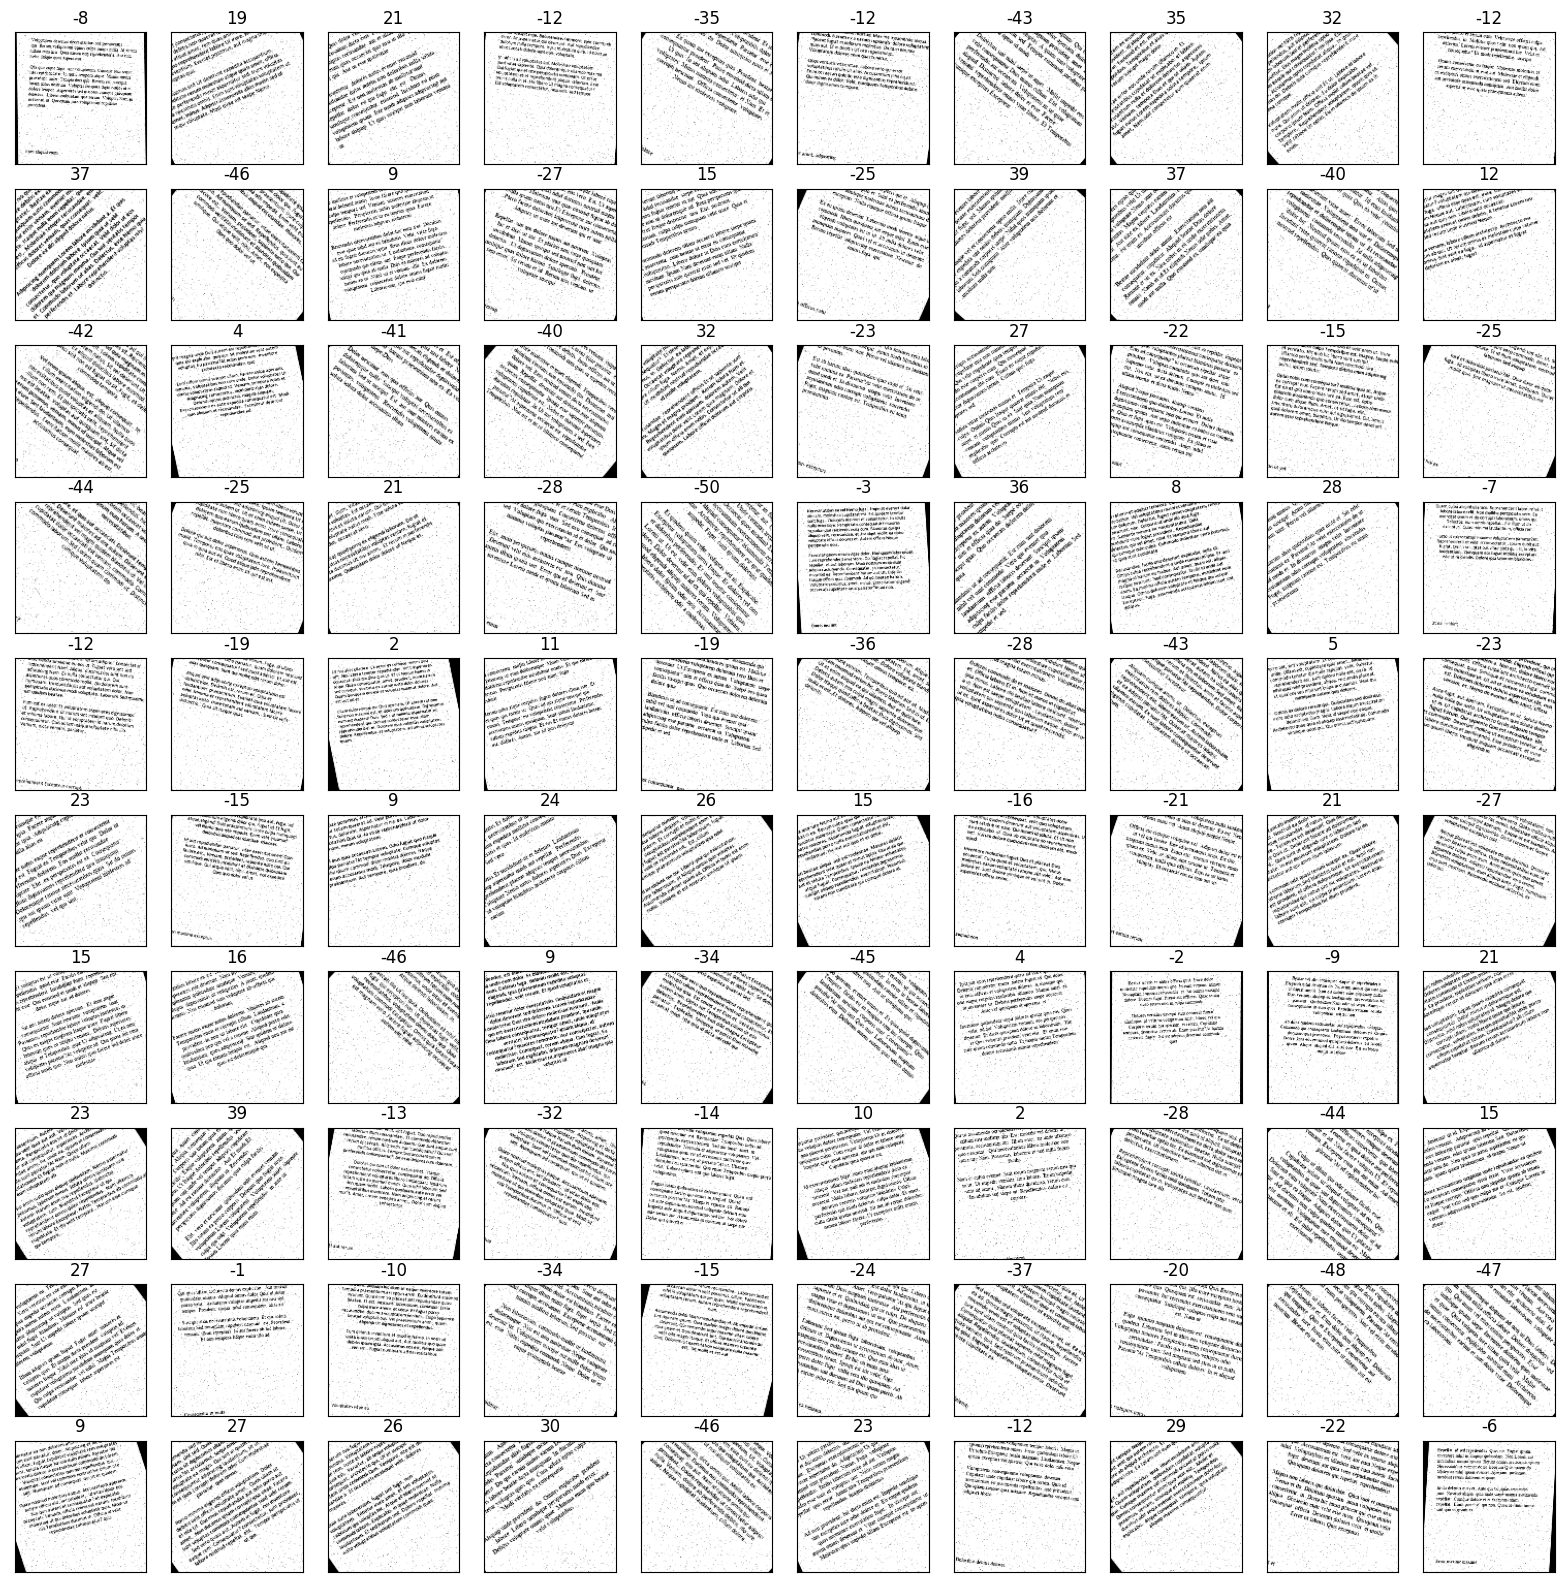

In [16]:
N = len(new_images)

sampled_image_indecies = random.sample(range(N), 100)
sampled_images = [Image.fromarray(new_images[i]) for i in sampled_image_indecies]
sampled_labels = [new_labels[i] for i in sampled_image_indecies]

display_image_grid(sampled_images, 10, sampled_labels)

## Preprocessing

Binarizing datset's images. The threshold is 0.5. 

In [17]:
nb_classes = np.unique(new_labels).__len__()
data = np.stack(new_images, axis=0)                            

X = data.copy()
Y = to_categorical(np.array(new_labels) + 45, nb_classes)      

X = X/255                                                      
X = np.where(X > 0.5, 1, 0)                                    

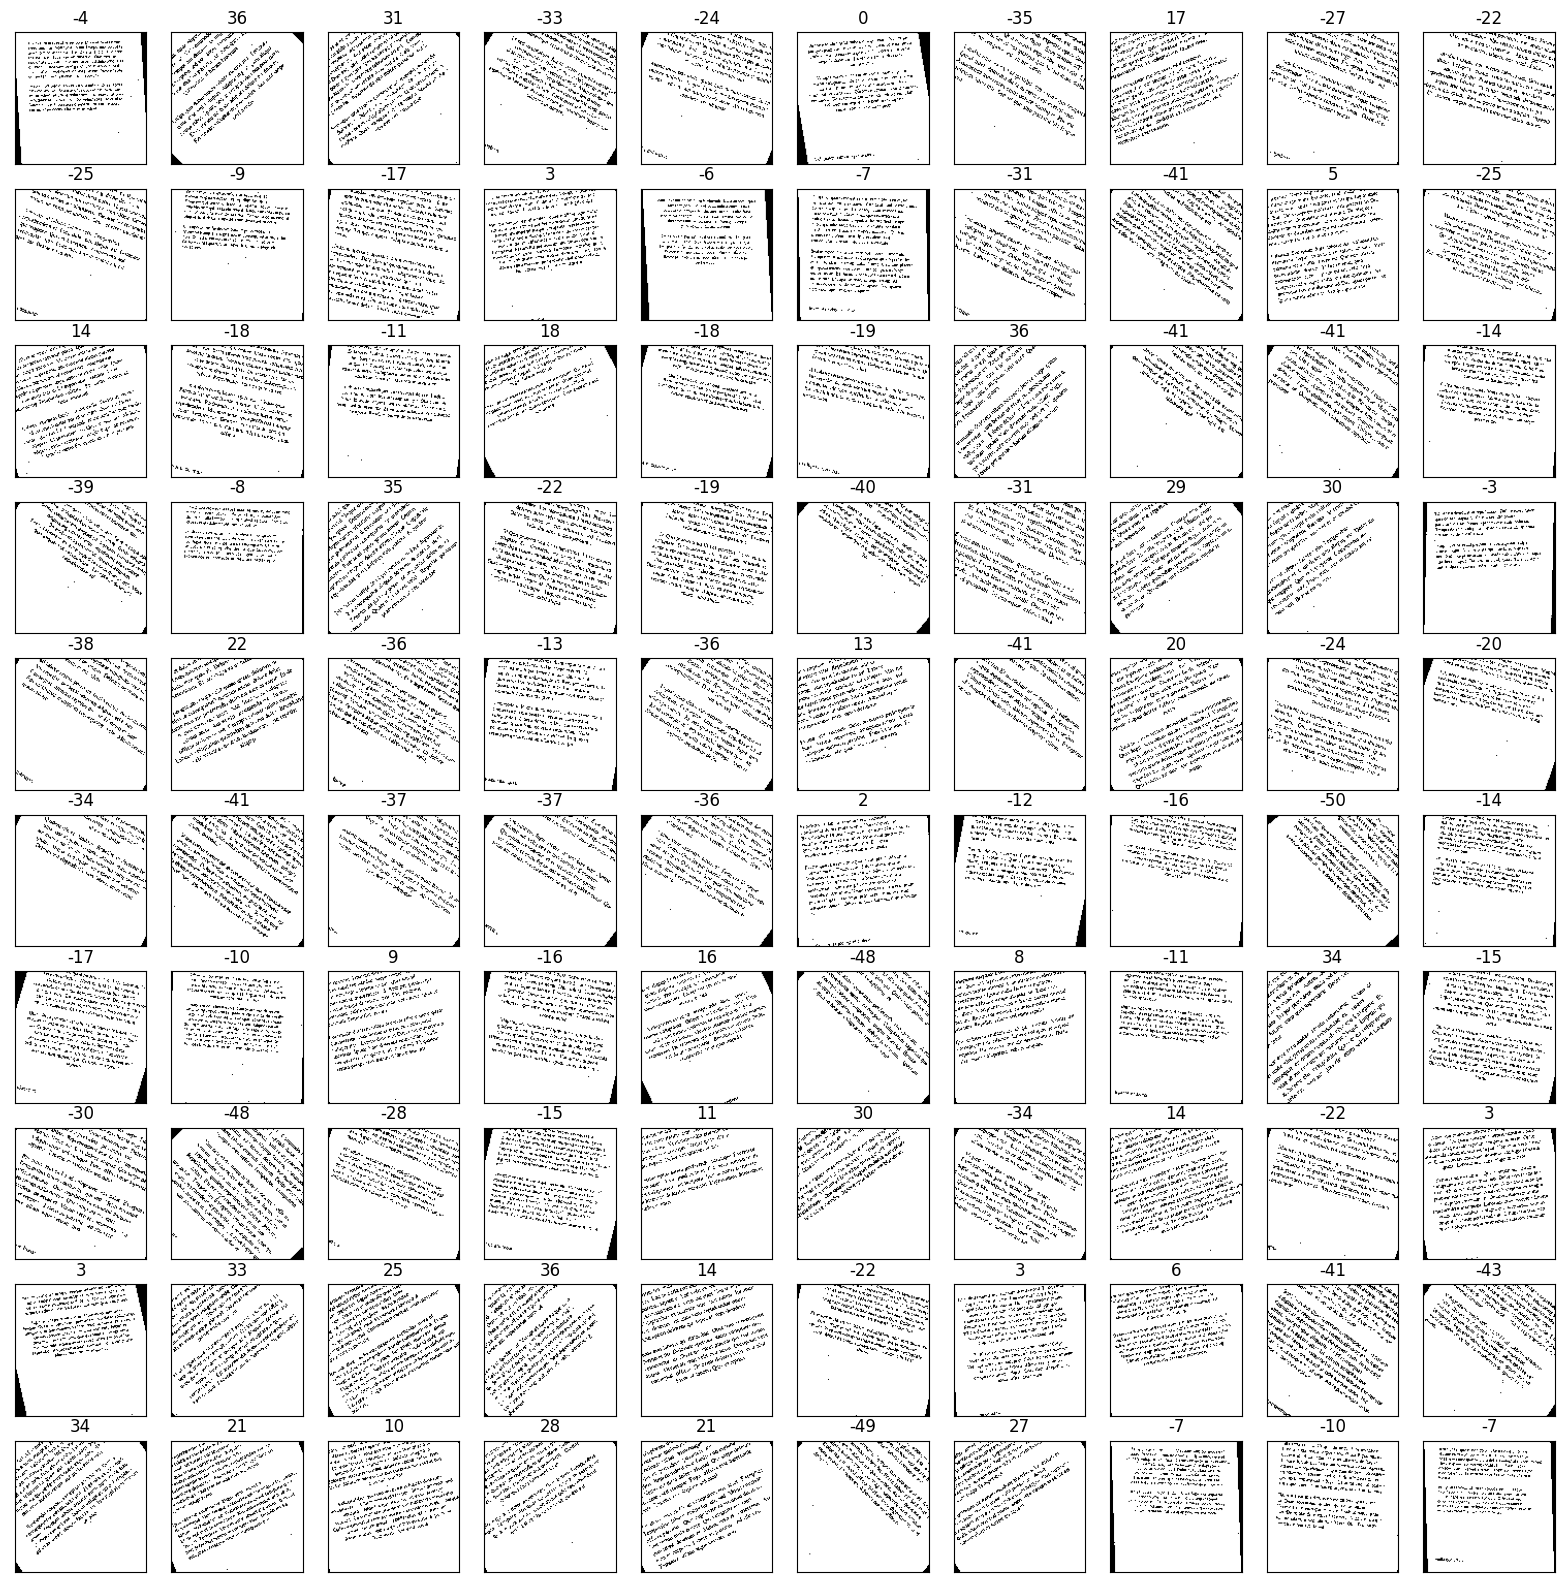

In [18]:
sampled_image_indecies = random.sample(range(N), 100)
sampled_images = [Image.fromarray((X[i]*255).astype(np.uint8)) for i in sampled_image_indecies]
sampled_labels = [new_labels[i] for i in sampled_image_indecies]

display_image_grid(sampled_images, 10, sampled_labels)

## Model

In [19]:
# number of convolutional filters to use
nb_filters = 64
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

In [20]:
nb_train_samples, img_height, img_width = X.shape
img_channels = 1
input_shape = (img_height, img_width, img_channels)

print('Input shape:', input_shape)
print(nb_train_samples, 'train samples')

Input shape: (128, 128, 1)
25000 train samples


### TensorFlow Model

In [21]:

input = Input(shape=(img_height, img_width, img_channels))
x = Conv2D(nb_filters, kernel_size, activation='relu')(input)
x = Conv2D(nb_filters, kernel_size, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(nb_filters, kernel_size, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(nb_filters, kernel_size, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(nb_classes, activation='softmax')(x)

model = Model(inputs=input, outputs=x)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                         

### Model Compilation

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer= tf.keras.optimizers.Adam(learning_rate=5e-4),
              metrics=[angle_error, 'acc'])

### Training Parameters

In [24]:
batch_size = 128
nb_epoch = 15

### CallBacks

In [25]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [26]:
tensorboard = TensorBoard()
plotlearning = PlotLearning()
early_stopping = EarlyStopping(patience=5)

### Model Fitting

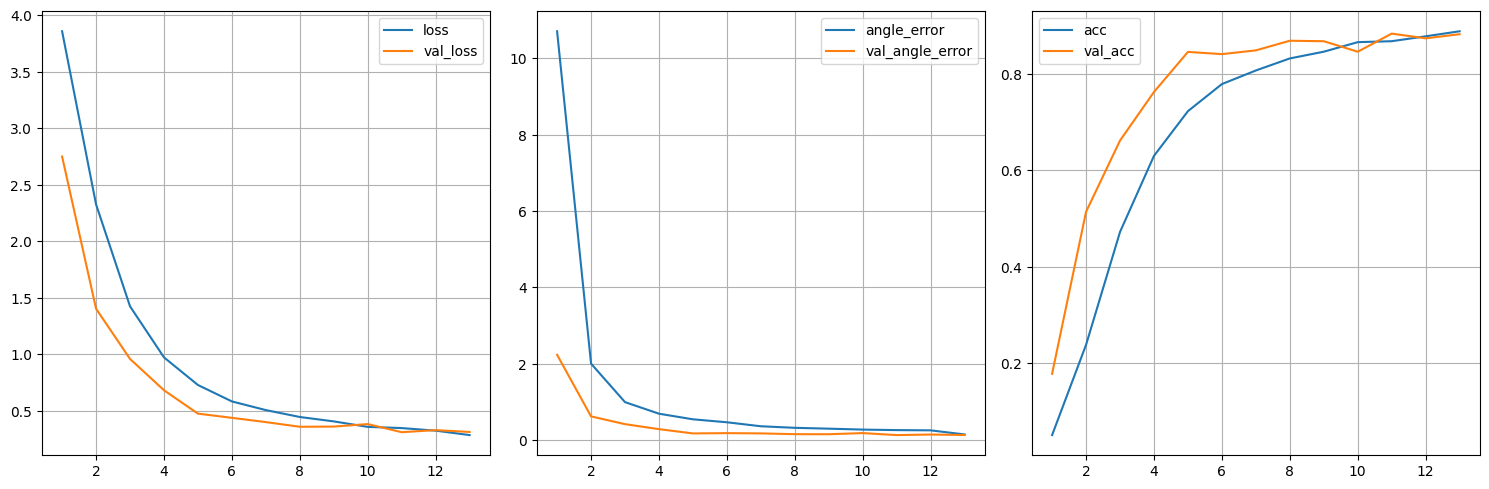

195/195 [==============================] - 63s 288ms/step - loss: 0.2868 - angle_error: 0.1432 - acc: 0.8889 - val_loss: 0.3144 - val_angle_error: 0.1287 - val_acc: 0.8828


In [27]:
model.fit(
    x = X,
    y = Y,
    batch_size=batch_size,
    steps_per_epoch=nb_train_samples / batch_size,
    epochs=nb_epoch,
    validation_split=0.2,
    verbose=1,
    callbacks=[tensorboard, plotlearning, early_stopping]
)

## Evaluation

In [28]:
test_df = pd.DataFrame(data={'image':list(map(lambda x:x.split('.')[0], test_list)), 'label':np.zeros(len(test_list), int)})

In [29]:
test_images = []
for image_name in test_df['image'].values:
    image_path = os.path.join(image_paths, image_name+'.png')
    img = Image.open(image_path)
    img = np.array(img)
    new_img = generate_rotated_image(img,
                                     0,
                                     size=(128, 128),
                                     crop_center=False,
                                     crop_largest_rect=False)
    test_images.append(new_img)

In [30]:
X_test = np.stack(test_images)
X_test = X_test / 255
X_test = np.where(X_test > 0.5, 1, 0)

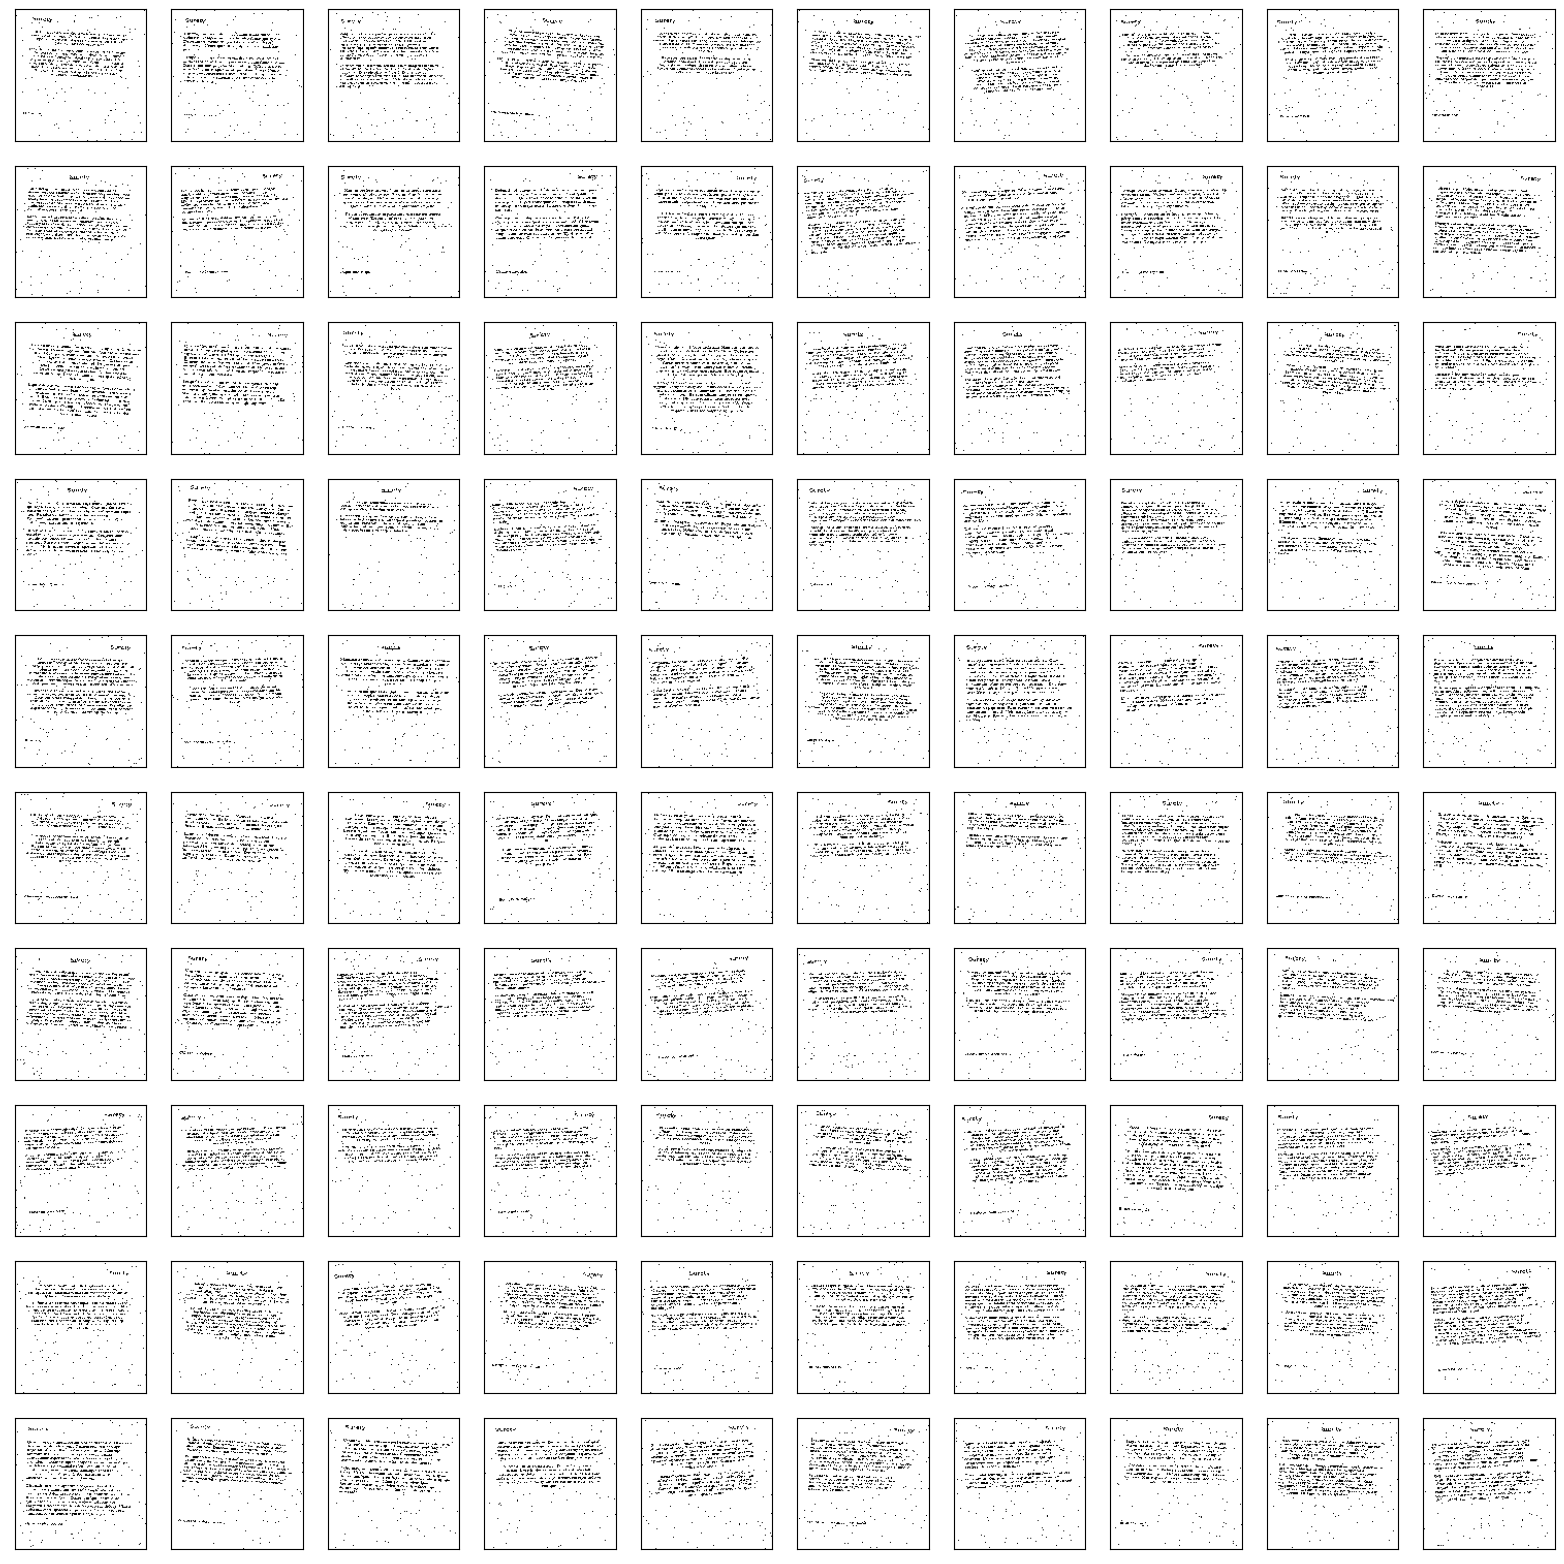

In [31]:
display_image_grid(X_test, 10)

In [32]:
predicted_angles = np.argmax(model(X_test), axis=1) - 45

In [33]:
corrected_test_images = []

for i, image_name in enumerate(test_df['image'].values):
    image_path = os.path.join(image_paths, image_name+'.png')
    img = Image.open(image_path)
    img = np.array(img)
    angle = predicted_angles[i]
    corrected_img = rotate(img, -angle)
    corrected_test_images.append(corrected_img)

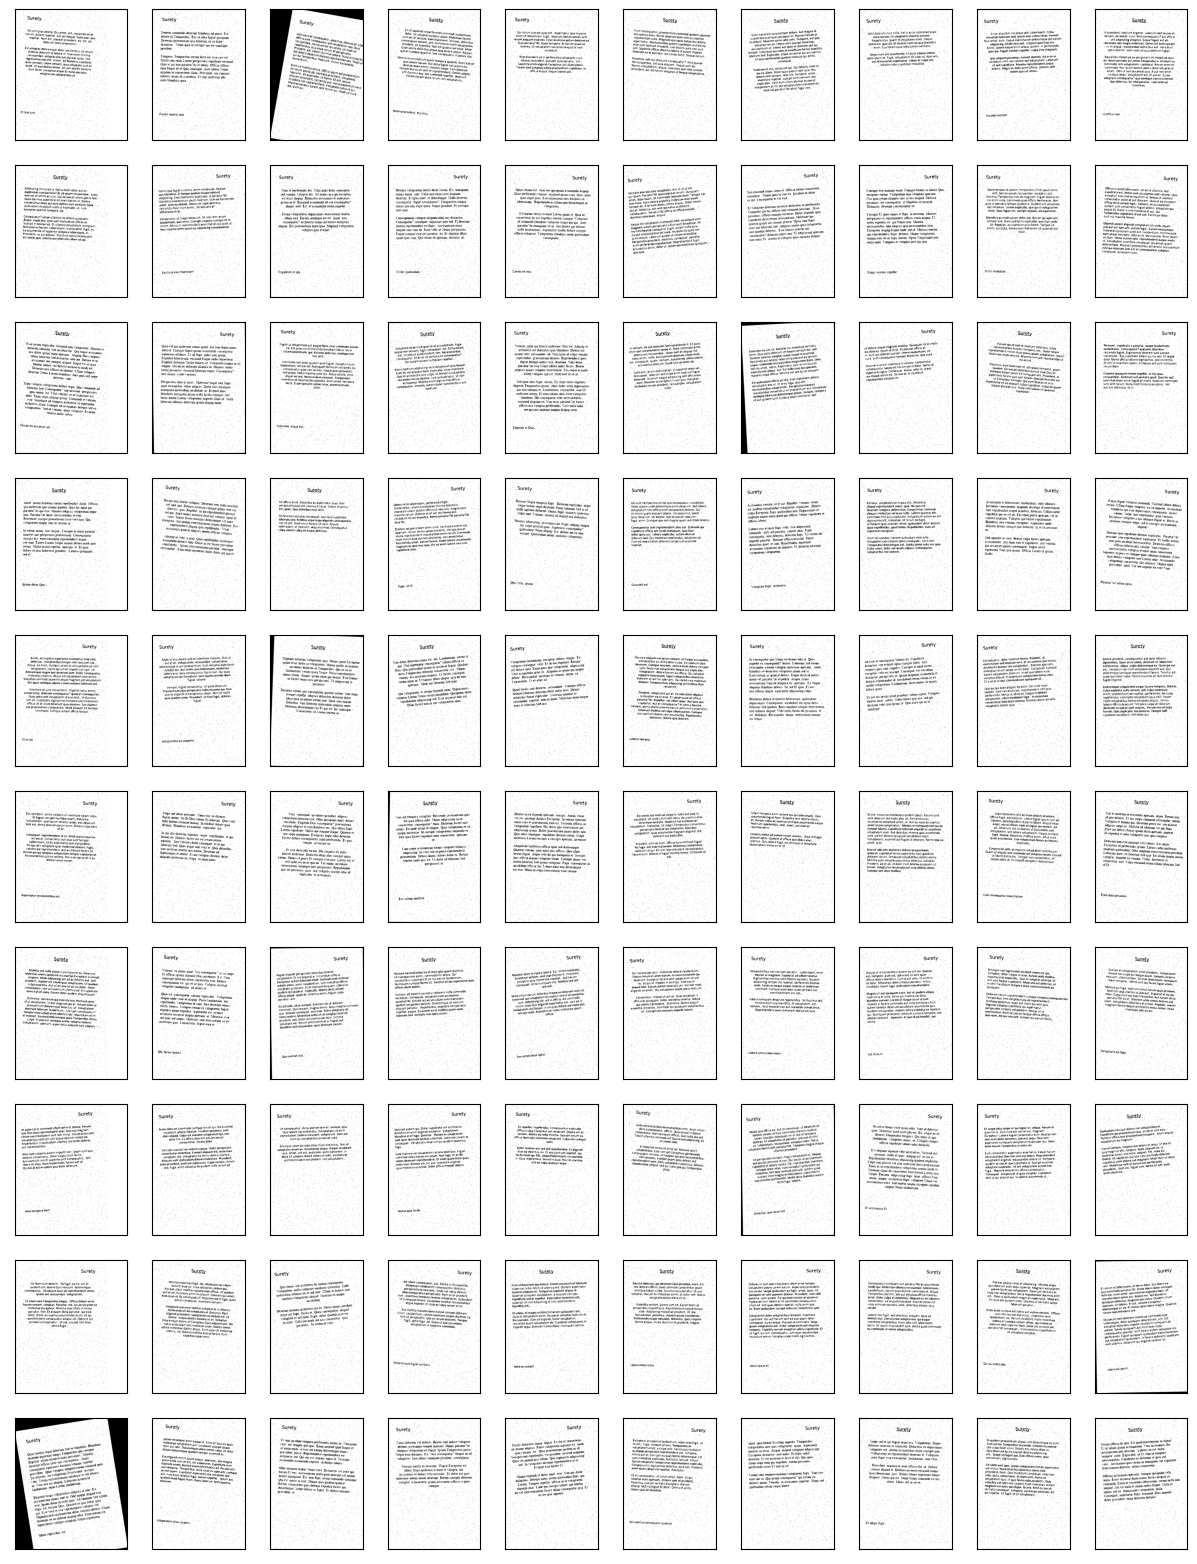

In [34]:
display_image_grid(corrected_test_images, 10)